# 🌿 DeepMaxent Tutorial: Species Distribution Modeling

## Introduction

Welcome to this tutorial on **DeepMaxent**, a deep learning approach for Species Distribution Modeling (SDM). In this notebook, we will:

1. **Load and explore** biodiversity occurrence data from GBIF
2. **Visualize** species occurrences on interactive maps
3. **Process environmental rasters** (WorldClim bioclimatic variables)
4. **Prepare training data** by aggregating occurrences at raster resolution
5. **Build input tensors** ready for the DeepMaxent model

This tutorial focuses on plant species observations from **Costa Rica** 🇨🇷.

---

## 📋 Table of Contents

1. [Import Libraries](#1-import-libraries)
2. [Load Biodiversity Data](#2-load-biodiversity-data)
3. [Data Exploration & Visualization](#3-data-exploration)
4. [Crop Environmental Rasters](#4-crop-rasters)
5. [Visualize Environmental Variables](#5-visualize-environment)
6. [Prepare Training Data](#6-prepare-data)
7. [Summary Statistics](#7-summary)

<a id="1-import-libraries"></a>
## 1. 📦 Import Libraries

We need several libraries for this tutorial:
- **pandas/numpy**: Data manipulation
- **rasterio**: Reading and processing raster files
- **matplotlib/cartopy**: Creating beautiful maps
- **torch**: Building tensors for deep learning
- **sklearn**: Data preprocessing

In [1]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Core libraries
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

# Geospatial libraries
import rasterio
from rasterio.windows import from_bounds
from rasterio.plot import show

# Machine Learning
import torch
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# DeepMaxent libraries
from librairies.model import deepmaxent_model
from librairies.losses import deepmaxent_loss
from librairies.utils import set_seed

# Set random seed for reproducibility
set_seed(42)

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

print("✅ All libraries loaded successfully!")

✅ All libraries loaded successfully!


<a id="2-load-biodiversity-data"></a>
## 2. 🦜 Load Biodiversity Data

We'll load occurrence data from the **Global Biodiversity Information Facility (GBIF)**. This dataset contains species observations with their geographic coordinates, taxonomy, and observation metadata.

In [2]:
# Load the biodiversity dataset
df = pd.read_csv('data/tutorial/biodiversity_data.csv', sep='\t', low_memory=False)

print(f"📊 Dataset shape: {df.shape[0]:,} observations × {df.shape[1]} columns")
print(f"\n🔤 Available columns:\n{df.columns.tolist()[:15]}...")

# Display first few rows
df.head(3)

📊 Dataset shape: 26,670 observations × 50 columns

🔤 Available columns:
['gbifID', 'datasetKey', 'occurrenceID', 'kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species', 'infraspecificEpithet', 'taxonRank', 'scientificName', 'verbatimScientificName', 'verbatimScientificNameAuthorship']...


,gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,...,identifiedBy,dateIdentified,license,rightsHolder,recordedBy,typeStatus,establishmentMeans,lastInterpreted,mediaType,issue
0,991957019,9661bc40-f762-11e1-a439-00145eb45e9a,NaN,Animalia,Chordata,Squamata,NaN,Colubridae,Trimetopon,Trimetopon simile,...,NaN,NaN,CC_BY_4_0,NaN,NaN,NaN,NaN,2025-08-13T06:26:51.213Z,NaN,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS8...
1,991940453,9661bc40-f762-11e1-a439-00145eb45e9a,NaN,Animalia,Chordata,Amphibia,Anura,Eleutherodactylidae,Eleutherodactylus,Eleutherodactylus rhodesi,...,NaN,NaN,CC_BY_4_0,NaN,NaN,NaN,NaN,2025-08-13T06:26:57.208Z,NaN,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS8...
2,991853602,9661bc40-f762-11e1-a439-00145eb45e9a,NaN,Animalia,Chordata,Amphibia,Anura,Phyllomedusidae,Agalychnis,Agalychnis lemur,...,NaN,NaN,CC_BY_4_0,NaN,NaN,NaN,NaN,2025-08-13T06:26:38.847Z,NaN,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS8...


<a id="3-data-exploration"></a>
## 3. 🔍 Data Exploration & Visualization

Let's explore the dataset to understand what kind of data we have:

In [3]:
# Clean coordinates and filter valid data
df['decimalLatitude'] = pd.to_numeric(df['decimalLatitude'], errors='coerce')
df['decimalLongitude'] = pd.to_numeric(df['decimalLongitude'], errors='coerce')

# Remove rows with missing coordinates or species
df_clean = df.dropna(subset=['decimalLatitude', 'decimalLongitude', 'species'])

print(f"📍 Valid observations with coordinates: {len(df_clean):,}")
print(f"\n📈 Distribution by Kingdom:")
print(df_clean['kingdom'].value_counts())

print(f"\n📋 Observation types:")
print(df_clean['basisOfRecord'].value_counts())

📍 Valid observations with coordinates: 26,670

📈 Distribution by Kingdom:
kingdom
Animalia    15351
Plantae     11313
Fungi           6
Name: count, dtype: int64

📋 Observation types:
basisOfRecord
HUMAN_OBSERVATION      13645
PRESERVED_SPECIMEN     12712
MATERIAL_CITATION        224
MACHINE_OBSERVATION       50
OCCURRENCE                35
LIVING_SPECIMEN            2
MATERIAL_SAMPLE            2
Name: count, dtype: int64


In [4]:
# Filter for plant observations only (human observations are most reliable)
df_filtered = df_clean[
    (df_clean['kingdom'] == 'Plantae') & 
    (df_clean['basisOfRecord'] == 'HUMAN_OBSERVATION')
].copy()

print(f"🌿 Plant observations (human observations): {len(df_filtered):,}")
print(f"🌱 Number of unique species: {df_filtered['species'].nunique():,}")

🌿 Plant observations (human observations): 1,145
🌱 Number of unique species: 102


In [5]:
# Summary statistics of filtered data
print("📊 Dataset Summary")
print("=" * 50)
print(f"Total observations: {len(df_filtered):,}")
print(f"Unique species: {df_filtered['species'].nunique():,}")
print(f"Unique locations: {df_filtered.groupby(['decimalLongitude', 'decimalLatitude']).ngroups:,}")
print(f"\n📍 Geographic extent:")
print(f"   Longitude: [{df_filtered['decimalLongitude'].min():.3f}, {df_filtered['decimalLongitude'].max():.3f}]")
print(f"   Latitude:  [{df_filtered['decimalLatitude'].min():.3f}, {df_filtered['decimalLatitude'].max():.3f}]")
print(f"\n📅 Year range: {int(df_filtered['year'].min())} - {int(df_filtered['year'].max())}")

📊 Dataset Summary
Total observations: 1,145
Unique species: 102
Unique locations: 1,040

📍 Geographic extent:
   Longitude: [-85.917, -82.630]
   Latitude:  [8.234, 11.189]

📅 Year range: 1989 - 2025


### 3.1 🗺️ Map of Species Occurrences

Let's visualize where the species observations are located. This is crucial to understand the spatial distribution of our data and identify potential sampling biases.

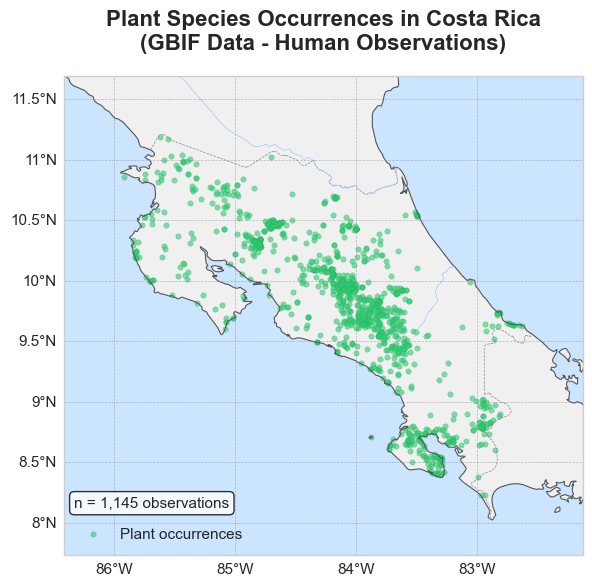

In [6]:
# Create a beautiful map showing all occurrences
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Define map extent with padding
padding = 0.5
extent = [
    df_filtered['decimalLongitude'].min() - padding,
    df_filtered['decimalLongitude'].max() + padding,
    df_filtered['decimalLatitude'].min() - padding,
    df_filtered['decimalLatitude'].max() + padding
]
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND, facecolor='#f0f0f0', edgecolor='none')
ax.add_feature(cfeature.OCEAN, facecolor='#cce5ff')
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='#555555')
ax.add_feature(cfeature.BORDERS, linestyle='--', linewidth=0.5, edgecolor='#888888')
ax.add_feature(cfeature.RIVERS, linewidth=0.5, edgecolor='#99ccff')

# Plot occurrence points
scatter = ax.scatter(
    df_filtered['decimalLongitude'], 
    df_filtered['decimalLatitude'],
    c='#2ecc71',
    s=15,
    alpha=0.6,
    edgecolor='#27ae60',
    linewidth=0.3,
    transform=ccrs.PlateCarree(),
    label='Plant occurrences'
)

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Title and legend
ax.set_title('Plant Species Occurrences in Costa Rica\n(GBIF Data - Human Observations)', 
             fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='lower left', fontsize=11)

# Add observation count annotation
ax.text(0.02, 0.1, f'n = {len(df_filtered):,} observations', 
        transform=ax.transAxes, fontsize=11, 
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

### 3.2 📊 Top Species Distribution

Let's look at the most frequently observed species in our dataset:

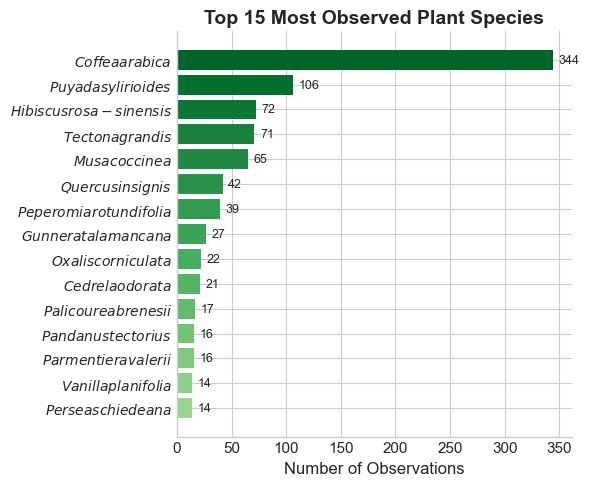

 Distribution summary:
   Most observed species: Coffea arabica (344 obs)
   Median obs per species: 2


In [7]:
# Top 15 most observed species
top_species = df_filtered['species'].value_counts().head(15)

fig, ax = plt.subplots(figsize=(6, 5))

# Create horizontal bar chart
colors_gradient = plt.cm.Greens(np.linspace(0.4, 0.9, len(top_species)))[::-1]
bars = ax.barh(range(len(top_species)), top_species.values, color=colors_gradient)

# Customize
ax.set_yticks(range(len(top_species)))
ax.set_yticklabels([f'$\it{{{s}}}$' for s in top_species.index], fontsize=10)  # Italic for species names
ax.invert_yaxis()
ax.set_xlabel('Number of Observations', fontsize=12)
ax.set_title('Top 15 Most Observed Plant Species', fontsize=14, fontweight='bold')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, top_species.values)):
    ax.text(val + 5, i, f'{val:,}', va='center', fontsize=9)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

print(f" Distribution summary:")
print(f"   Most observed species: {top_species.index[0]} ({top_species.values[0]:,} obs)")
print(f"   Median obs per species: {df_filtered['species'].value_counts().median():.0f}")

### 3.3 📅 Temporal Distribution of Observations

Understanding when observations were made helps identify temporal sampling bias:

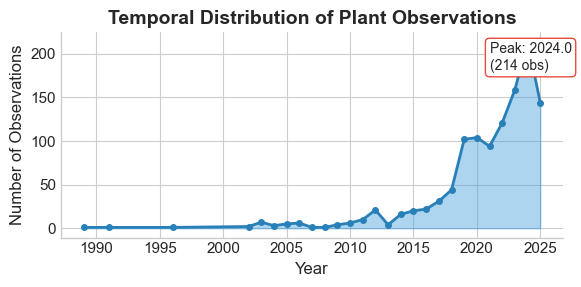

In [8]:
# Temporal distribution
year_counts = df_filtered['year'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(6, 3))

ax.fill_between(year_counts.index, year_counts.values, alpha=0.4, color='#3498db')
ax.plot(year_counts.index, year_counts.values, color='#2980b9', linewidth=2, marker='o', markersize=4)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Number of Observations', fontsize=12)
ax.set_title('Temporal Distribution of Plant Observations', fontsize=14, fontweight='bold')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Highlight peak year
peak_year = year_counts.idxmax()
peak_count = year_counts.max()
ax.annotate(f'Peak: {peak_year}\n({peak_count:,} obs)', 
            xy=(peak_year, peak_count), 
            xytext=(peak_year-3, peak_count*0.85),
            fontsize=10,
            arrowprops=dict(arrowstyle='->', color='#e74c3c'),
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='#e74c3c'))

plt.tight_layout()
plt.show()

### 3.4 🔥 Observation Density Heatmap

A density map helps identify areas with high sampling effort:

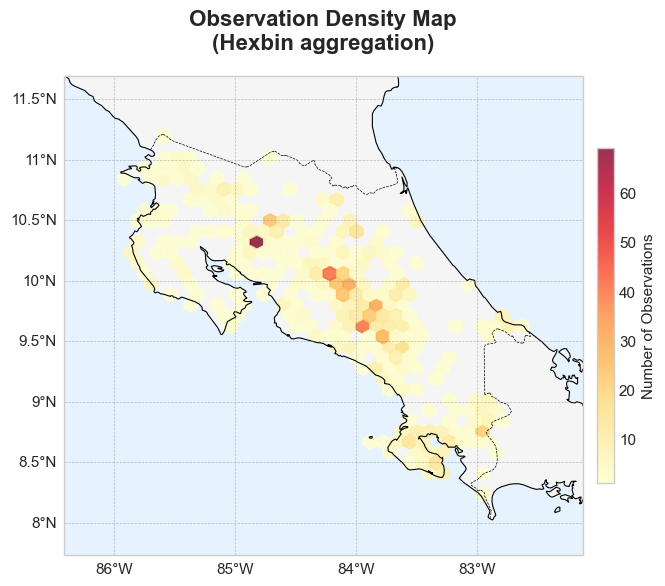

In [9]:
# Create density heatmap
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Define map extent
padding = 0.5
extent = [
    df_filtered['decimalLongitude'].min() - padding,
    df_filtered['decimalLongitude'].max() + padding,
    df_filtered['decimalLatitude'].min() - padding,
    df_filtered['decimalLatitude'].max() + padding
]
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND, facecolor='#f5f5f5', edgecolor='none')
ax.add_feature(cfeature.OCEAN, facecolor='#e6f3ff')
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle='--', linewidth=0.5)

# Create hexbin density plot
hb = ax.hexbin(
    df_filtered['decimalLongitude'], 
    df_filtered['decimalLatitude'],
    gridsize=30,
    cmap='YlOrRd',
    mincnt=1,
    transform=ccrs.PlateCarree(),
    alpha=0.8
)

# Add colorbar
cbar = plt.colorbar(hb, ax=ax, shrink=0.7, pad=0.02)
cbar.set_label('Number of Observations', fontsize=11)

# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

ax.set_title('Observation Density Map\n(Hexbin aggregation)', fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

<a id="4-crop-rasters"></a>
## 4. 🗺️ Crop Environmental Rasters

Now we need to prepare our environmental data. We're using **WorldClim bioclimatic variables** at 10 arc-minutes resolution (~18.5 km at the equator). 

These 19 bioclimatic variables are derived from temperature and precipitation data:

| Variable | Description |
|----------|-------------|
| BIO1 | Annual Mean Temperature |
| BIO2 | Mean Diurnal Range |
| BIO3 | Isothermality |
| BIO4 | Temperature Seasonality |
| BIO5-6 | Max/Min Temperature |
| BIO7 | Temperature Annual Range |
| BIO8-11 | Temperature of Wettest/Driest/Warmest/Coldest Quarter |
| BIO12 | Annual Precipitation |
| BIO13-14 | Precipitation of Wettest/Driest Month |
| BIO15 | Precipitation Seasonality |
| BIO16-19 | Precipitation of Wettest/Driest/Warmest/Coldest Quarter |

We'll crop these global rasters to our study area extent.

In [11]:
# Define study area extent based on occurrence data
buffer = 0.1  # Small buffer around occurrences

min_longitude = df_filtered['decimalLongitude'].min() - buffer
max_longitude = df_filtered['decimalLongitude'].max() + buffer
min_latitude = df_filtered['decimalLatitude'].min() - buffer
max_latitude = df_filtered['decimalLatitude'].max() + buffer

print("📍 Study Area Extent:")
print(f"   Longitude: [{min_longitude:.4f}, {max_longitude:.4f}]")
print(f"   Latitude:  [{min_latitude:.4f}, {max_latitude:.4f}]")
print(f"   Area span: {max_longitude - min_longitude:.2f}° × {max_latitude - min_latitude:.2f}°")

# Setup folders
input_folder = 'data/tutorial/rasters'
# input_folder = 'E:/chelsa_data/historical_1981-2010'
output_folder = 'data/tutorial/cropped_rasters'
os.makedirs(output_folder, exist_ok=True)

# List available rasters
raster_files = sorted([f for f in os.listdir(input_folder) if f.endswith('.tif')])
print(f"\n📂 Found {len(raster_files)} raster files to crop")

📍 Study Area Extent:
   Longitude: [-86.0172, -82.5302]
   Latitude:  [8.1340, 11.2894]
   Area span: 3.49° × 3.16°

📂 Found 19 raster files to crop


In [ ]:
# Crop all rasters to the study extent
print("✂️ Cropping rasters to study area...")

for filename in tqdm(raster_files, desc="Processing"):
    input_path = os.path.join(input_folder, filename)
    output_path = os.path.join(output_folder, filename)
    
    with rasterio.open(input_path) as src:
        # Get the window for our extent
        window = from_bounds(
            min_longitude, min_latitude, 
            max_longitude, max_latitude, 
            transform=src.transform
        )
        
        # Read cropped data
        data = src.read(window=window)
        
        # Update metadata
        meta = src.meta.copy()
        meta.update({
            'height': int(window.height),
            'width': int(window.width),
            'transform': rasterio.windows.transform(window, src.transform)
        })
        
        # Write cropped raster
        if window.height > 0 and window.width > 0:
            with rasterio.open(output_path, 'w', **meta) as dst:
                dst.write(data)

print(f"\n✅ Successfully cropped {len(raster_files)} rasters!")

# Check the cropped raster dimensions
with rasterio.open(os.path.join(output_folder, raster_files[0])) as src:
    print(f"\n📐 Cropped raster dimensions: {src.width} × {src.height} pixels")
    print(f"   Resolution: {abs(src.transform[0]):.4f}° (~{abs(src.transform[0]) * 111:.1f} km)")

✂️ Cropping rasters to study area...


Processing: 100%|██████████| 19/19 [00:02<00:00,  7.82it/s]


✅ Successfully cropped 19 rasters!

📐 Cropped raster dimensions: 418 × 378 pixels
   Resolution: 0.0083° (~0.9 km)


<a id="5-visualize-environment"></a>
## 5. 🌡️ Visualize Environmental Variables

Let's visualize some key bioclimatic variables along with our occurrence data:

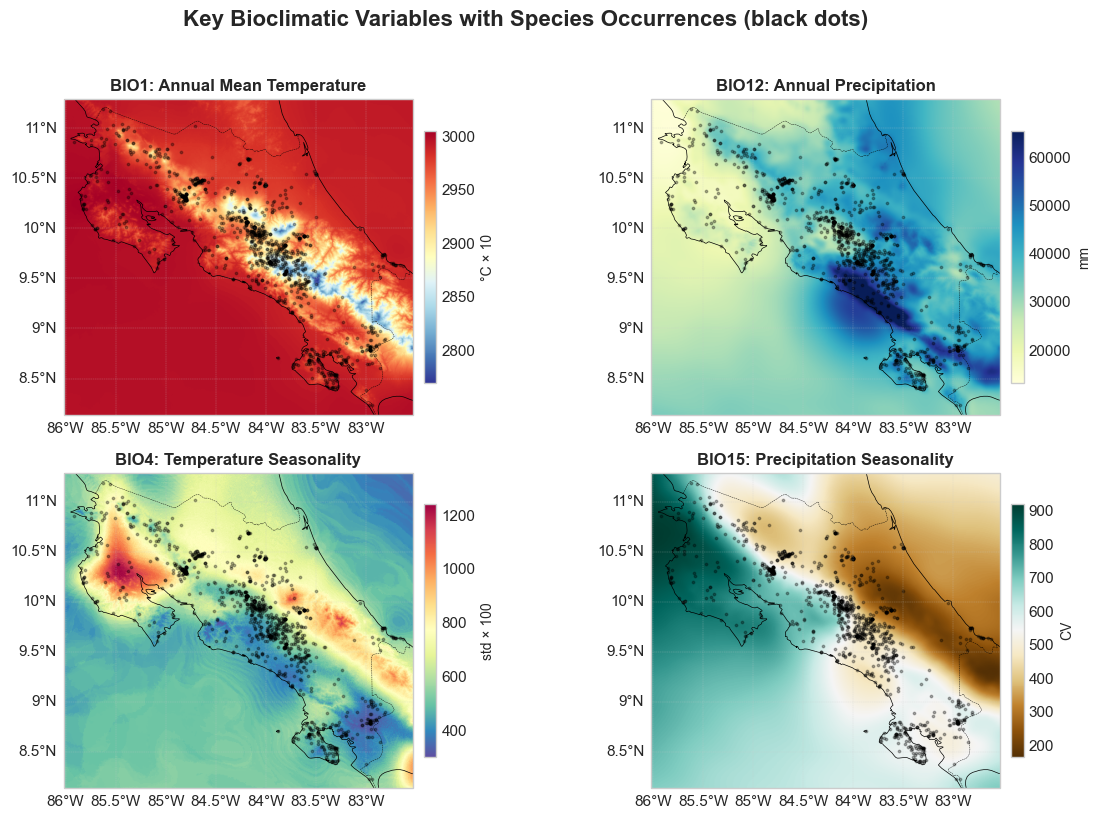

In [12]:
# Select key variables to visualize
variables_to_plot = [
    ('CHELSA_bio1_1981-2010_V.2.1.tif', 'BIO1: Annual Mean Temperature', '°C × 10', 'RdYlBu_r'),
    ('CHELSA_bio12_1981-2010_V.2.1.tif', 'BIO12: Annual Precipitation', 'mm', 'YlGnBu'),
    ('CHELSA_bio4_1981-2010_V.2.1.tif', 'BIO4: Temperature Seasonality', 'std × 100', 'Spectral_r'),
    ('CHELSA_bio15_1981-2010_V.2.1.tif', 'BIO15: Precipitation Seasonality', 'CV', 'BrBG')
]

fig, axes = plt.subplots(2, 2, figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for ax, (filename, title, unit, cmap) in zip(axes, variables_to_plot):
    filepath = os.path.join(output_folder, filename)
    
    with rasterio.open(filepath) as src:
        data = src.read(1).astype(np.float32)
        extent_raster = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
        nodata = src.nodata
        
        # Mask nodata values and any extreme values that could cause overflow
        if nodata is not None:
            data = np.ma.masked_where(
                (data == nodata) | (np.abs(data) > 1e10) | ~np.isfinite(data), 
                data
            )
        else:
            data = np.ma.masked_where((np.abs(data) > 1e10) | ~np.isfinite(data), data)
    
    # Add features
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle='--', linewidth=0.3)
    
    # Plot raster
    im = ax.imshow(data, extent=extent_raster, origin='upper', cmap=cmap, 
                   transform=ccrs.PlateCarree())
    
    # Overlay occurrences
    ax.scatter(df_filtered['decimalLongitude'], df_filtered['decimalLatitude'],
               c='black', s=3, alpha=0.3, transform=ccrs.PlateCarree())
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.8, pad=0.02)
    cbar.set_label(unit, fontsize=10)
    
    # Gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.3, alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    
    ax.set_title(title, fontsize=12, fontweight='bold')

plt.suptitle('Key Bioclimatic Variables with Species Occurrences (black dots)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

<a id="6-prepare-data"></a>
## 6. 📊 Prepare Training Data

Now we'll prepare the data for DeepMaxent by:

1. **Extracting environmental values** at each occurrence location
2. **Aggregating occurrences** by raster cell (multiple observations at the same location)
3. **Building the occurrence count matrix** (y) where each entry represents the number of observations per species per location

### 6.1 Extract Environmental Values at Occurrence Points

In [14]:
# Get the raster resolution info
rasters_dir = 'data/tutorial/cropped_rasters/'
raster_files = sorted([f for f in os.listdir(rasters_dir) if f.endswith('.tif')])

# Get raster properties
with rasterio.open(os.path.join(rasters_dir, raster_files[0])) as src:
    raster_resolution = abs(src.transform[0])
    raster_transform = src.transform
    raster_crs = src.crs

print(f"📐 Raster resolution: {raster_resolution:.4f}° (~{raster_resolution * 111:.1f} km)")
print(f"📁 Number of environmental variables: {len(raster_files)}")
print(f"\n📋 Variables:")
for i, f in enumerate(raster_files, 1):
    print(f"   {i:2d}. {f}")

📐 Raster resolution: 0.0083° (~0.9 km)
📁 Number of environmental variables: 19

📋 Variables:
    1. CHELSA_bio10_1981-2010_V.2.1.tif
    2. CHELSA_bio11_1981-2010_V.2.1.tif
    3. CHELSA_bio12_1981-2010_V.2.1.tif
    4. CHELSA_bio13_1981-2010_V.2.1.tif
    5. CHELSA_bio14_1981-2010_V.2.1.tif
    6. CHELSA_bio15_1981-2010_V.2.1.tif
    7. CHELSA_bio16_1981-2010_V.2.1.tif
    8. CHELSA_bio17_1981-2010_V.2.1.tif
    9. CHELSA_bio18_1981-2010_V.2.1.tif
   10. CHELSA_bio19_1981-2010_V.2.1.tif
   11. CHELSA_bio1_1981-2010_V.2.1.tif
   12. CHELSA_bio2_1981-2010_V.2.1.tif
   13. CHELSA_bio3_1981-2010_V.2.1.tif
   14. CHELSA_bio4_1981-2010_V.2.1.tif
   15. CHELSA_bio5_1981-2010_V.2.1.tif
   16. CHELSA_bio6_1981-2010_V.2.1.tif
   17. CHELSA_bio7_1981-2010_V.2.1.tif
   18. CHELSA_bio8_1981-2010_V.2.1.tif
   19. CHELSA_bio9_1981-2010_V.2.1.tif


### 6.2 Aggregate Occurrences by Raster Cell

Multiple species observations can occur at the same location. We need to:
1. Group observations by unique coordinates
2. Count occurrences per species at each location
3. This creates our **occurrence count matrix (y)**

In [15]:
# Aggregate observations by unique location
# This groups all species observations at each coordinate pair
df_unique = df_filtered.groupby(['decimalLongitude', 'decimalLatitude']).agg({
    'species': list  # Collect all species observed at this location
}).reset_index()

# Get unique species list and create index mapping
species_list = df_filtered['species'].unique()
num_species = len(species_list)
species_to_idx = {species: idx for idx, species in enumerate(species_list)}

print(f"📍 Unique locations: {len(df_unique):,}")
print(f"🌱 Unique species: {num_species:,}")
print(f"📊 From {len(df_filtered):,} individual observations")
print(f"\n📐 Aggregation ratio: {len(df_filtered) / len(df_unique):.1f} observations per location (avg)")

📍 Unique locations: 1,040
🌱 Unique species: 102
📊 From 1,145 individual observations

📐 Aggregation ratio: 1.1 observations per location (avg)


### 6.3 Build Training Tensors

Now we create:
- **X tensor** (environmental features): shape `(n_locations, n_variables)`
- **y tensor** (occurrence counts): shape `(n_locations, n_species)`

In [16]:
# Initialize tensors
num_locations = len(df_unique)
num_variables = len(raster_files)

X_tensor = torch.zeros((num_locations, num_variables), dtype=torch.float32)
y_tensor = torch.zeros((num_locations, num_species), dtype=torch.float32)

# Build occurrence count matrix (y)
print("🔢 Building occurrence count matrix...")
for idx, row in tqdm(df_unique.iterrows(), total=len(df_unique), desc="Processing locations"):
    species_at_location = row['species']
    for sp in species_at_location:
        y_tensor[idx, species_to_idx[sp]] += 1

# Extract environmental values at each location
print("\n🌡️ Extracting environmental values...")
coords = list(zip(df_unique['decimalLongitude'], df_unique['decimalLatitude']))

for var_idx, filename in enumerate(tqdm(raster_files, desc="Processing rasters")):
    filepath = os.path.join(rasters_dir, filename)
    
    with rasterio.open(filepath) as src:
        nodata = src.nodata
        # Convert to float first to allow NaN assignment
        values = np.array([val[0] for val in src.sample(coords)], dtype=np.float32)
        
        # Handle nodata values
        if nodata is not None:
            values[values == nodata] = np.nan
        
        X_tensor[:, var_idx] = torch.tensor(values, dtype=torch.float32)

print(f"\n✅ Tensor creation complete!")
print(f"   X (environmental features): {X_tensor.shape}")
print(f"   y (occurrence counts):      {y_tensor.shape}")

🔢 Building occurrence count matrix...


Processing locations: 100%|██████████| 1040/1040 [00:00<00:00, 10967.15it/s]



🌡️ Extracting environmental values...


Processing rasters: 100%|██████████| 19/19 [00:01<00:00, 18.11it/s]


✅ Tensor creation complete!
   X (environmental features): torch.Size([1040, 19])
   y (occurrence counts):      torch.Size([1040, 102])


<a id="7-summary"></a>
## 7. 📈 Summary Statistics & Data Quality Check

Let's examine the quality of our prepared data:

In [17]:
# Check for missing values
nan_mask = torch.isnan(X_tensor)
rows_with_nan = nan_mask.any(dim=1).sum().item()
total_nan = nan_mask.sum().item()

print("📊 DATA SUMMARY")
print("=" * 60)
print(f"\n🔢 Tensor Shapes:")
print(f"   X (features):   {X_tensor.shape} → {num_locations:,} locations × {num_variables} variables")
print(f"   y (occurrences): {y_tensor.shape} → {num_locations:,} locations × {num_species:,} species")

print(f"\n📈 Feature Statistics:")
for i, fname in enumerate(raster_files[:5]):
    var_name = fname.replace('wc2.1_10m_', '').replace('.tif', '')
    values = X_tensor[:, i]
    valid_values = values[~torch.isnan(values)]
    print(f"   {var_name}: min={valid_values.min():.1f}, max={valid_values.max():.1f}, mean={valid_values.mean():.1f}")
print(f"   ... and {len(raster_files) - 5} more variables")

print(f"\n⚠️ Missing Values:")
print(f"   Locations with NaN: {rows_with_nan:,} / {num_locations:,} ({100*rows_with_nan/num_locations:.1f}%)")
print(f"   Total NaN values: {total_nan:,}")

print(f"\n🌱 Species Occurrence Statistics:")
species_counts = y_tensor.sum(dim=0)
print(f"   Total occurrences in y: {y_tensor.sum().item():,.0f}")
print(f"   Species with data: {(species_counts > 0).sum().item():,} / {num_species:,}")
print(f"   Max occurrences per species: {species_counts.max().item():.0f}")
print(f"   Median occurrences per species: {torch.median(species_counts[species_counts > 0]).item():.0f}")

📊 DATA SUMMARY

🔢 Tensor Shapes:
   X (features):   torch.Size([1040, 19]) → 1,040 locations × 19 variables
   y (occurrences): torch.Size([1040, 102]) → 1,040 locations × 102 species

📈 Feature Statistics:
   CHELSA_bio10_1981-2010_V.2.1: min=2796.0, max=3022.0, mean=2948.7
   CHELSA_bio11_1981-2010_V.2.1: min=2782.0, max=2996.0, mean=2934.1
   CHELSA_bio12_1981-2010_V.2.1: min=13697.0, max=65535.0, mean=38994.0
   CHELSA_bio13_1981-2010_V.2.1: min=2885.0, max=11099.0, mean=5588.5
   CHELSA_bio14_1981-2010_V.2.1: min=15.0, max=2696.0, mean=913.1
   ... and 14 more variables

⚠️ Missing Values:
   Locations with NaN: 0 / 1,040 (0.0%)
   Total NaN values: 0

🌱 Species Occurrence Statistics:
   Total occurrences in y: 1,145
   Species with data: 102 / 102
   Max occurrences per species: 344
   Median occurrences per species: 2


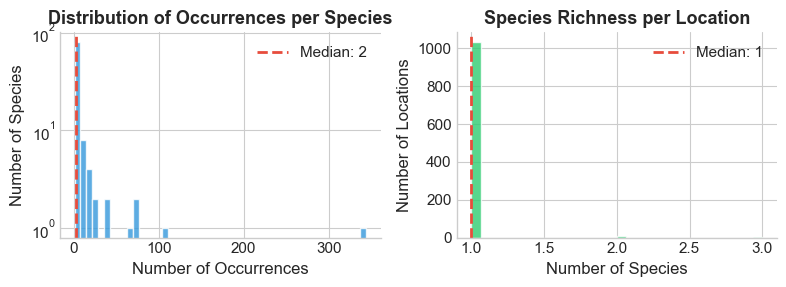

In [18]:
# Visualize species occurrence distribution
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Distribution of occurrences per species
ax1 = axes[0]
species_totals = y_tensor.sum(dim=0).numpy()
species_totals_nonzero = species_totals[species_totals > 0]

ax1.hist(species_totals_nonzero, bins=50, color='#3498db', edgecolor='white', alpha=0.8)
ax1.axvline(np.median(species_totals_nonzero), color='#e74c3c', linestyle='--', linewidth=2, 
            label=f'Median: {np.median(species_totals_nonzero):.0f}')
ax1.set_xlabel('Number of Occurrences', fontsize=12)
ax1.set_ylabel('Number of Species', fontsize=12)
ax1.set_title('Distribution of Occurrences per Species', fontsize=13, fontweight='bold')
ax1.legend()
ax1.set_yscale('log')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Distribution of species richness per location
ax2 = axes[1]
richness_per_location = (y_tensor > 0).sum(dim=1).numpy()

ax2.hist(richness_per_location, bins=30, color='#2ecc71', edgecolor='white', alpha=0.8)
ax2.axvline(np.median(richness_per_location), color='#e74c3c', linestyle='--', linewidth=2,
            label=f'Median: {np.median(richness_per_location):.0f}')
ax2.set_xlabel('Number of Species', fontsize=12)
ax2.set_ylabel('Number of Locations', fontsize=12)
ax2.set_title('Species Richness per Location', fontsize=13, fontweight='bold')
ax2.legend()
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

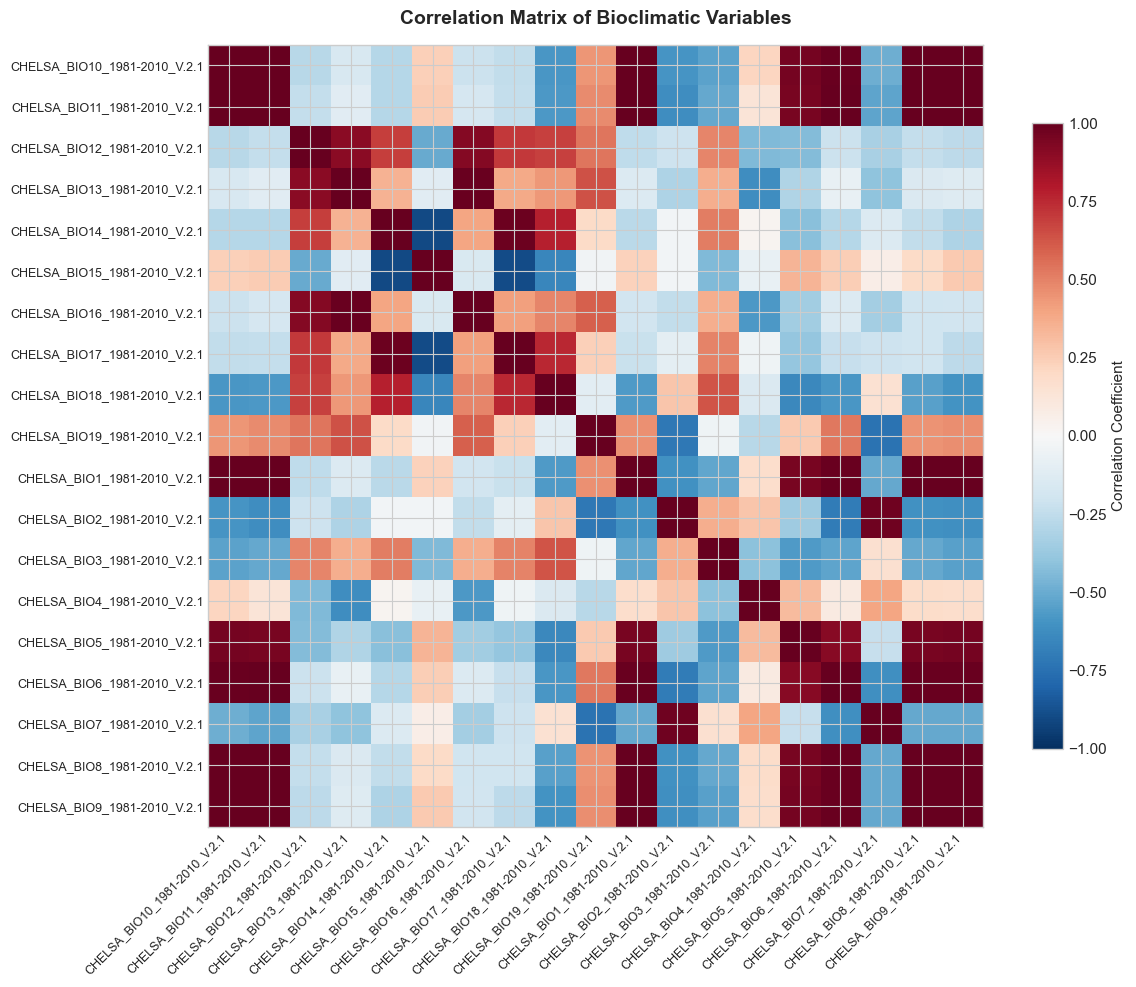


💡 Note: Highly correlated variables (|r| > 0.8) may cause multicollinearity issues.
   Consider feature selection or PCA for model training.


In [19]:
# Correlation matrix of environmental variables
fig, ax = plt.subplots(figsize=(12, 10))

# Calculate correlation matrix (ignoring NaN)
X_numpy = X_tensor.numpy()
valid_mask = ~np.isnan(X_numpy).any(axis=1)
corr_matrix = np.corrcoef(X_numpy[valid_mask].T)

# Variable names
var_names = [f.replace('wc2.1_10m_', '').replace('.tif', '').upper() for f in raster_files]

# Plot heatmap
im = ax.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('Correlation Coefficient', fontsize=11)

# Labels
ax.set_xticks(range(len(var_names)))
ax.set_yticks(range(len(var_names)))
ax.set_xticklabels(var_names, rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(var_names, fontsize=9)

ax.set_title('Correlation Matrix of Bioclimatic Variables', fontsize=14, fontweight='bold', pad=15)

plt.tight_layout()
plt.show()

print("\n💡 Note: Highly correlated variables (|r| > 0.8) may cause multicollinearity issues.")
print("   Consider feature selection or PCA for model training.")

### 7.1 🗺️ Map of Species Richness

Let's visualize the species richness (number of different species) at each location:

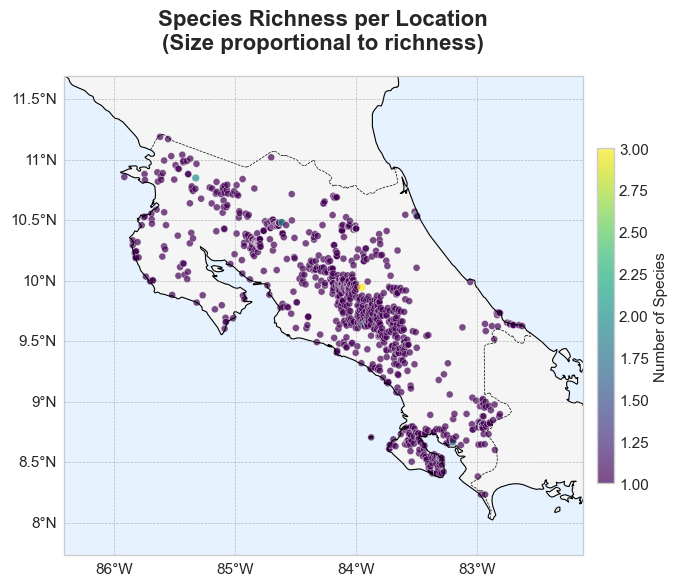

In [20]:
# Map species richness
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Calculate species richness per location
richness = (y_tensor > 0).sum(dim=1).numpy()

# Map extent
padding = 0.5
extent = [
    df_unique['decimalLongitude'].min() - padding,
    df_unique['decimalLongitude'].max() + padding,
    df_unique['decimalLatitude'].min() - padding,
    df_unique['decimalLatitude'].max() + padding
]
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Add features
ax.add_feature(cfeature.LAND, facecolor='#f5f5f5')
ax.add_feature(cfeature.OCEAN, facecolor='#e6f3ff')
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle='--', linewidth=0.5)

# Create colormap
scatter = ax.scatter(
    df_unique['decimalLongitude'],
    df_unique['decimalLatitude'],
    c=richness,
    cmap='viridis',
    s=20 + richness * 5,  # Size proportional to richness
    alpha=0.7,
    edgecolor='white',
    linewidth=0.3,
    transform=ccrs.PlateCarree()
)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax, shrink=0.7, pad=0.02)
cbar.set_label('Number of Species', fontsize=11)

# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

ax.set_title('Species Richness per Location\n(Size proportional to richness)', 
             fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

## 🎯 Intermediate Summary

We have successfully:

1. ✅ **Loaded and explored** GBIF biodiversity data from Costa Rica
2. ✅ **Visualized** species occurrences on interactive maps
3. ✅ **Cropped environmental rasters** (WorldClim bioclimatic variables) to the study area
4. ✅ **Built training tensors**:
   - **X**: Environmental features at each unique location
   - **y**: Species occurrence counts (multi-label target)

---

## 8. 🔀 Spatial Block Split for Train/Validation

To properly evaluate our model, we need to split our data into training and validation sets. However, using random splits can lead to **spatial autocorrelation** issues where nearby points end up in both sets.

Instead, we'll use a **spatial block split** based on geographic coordinates, ensuring that training and validation data come from different geographic regions.

In [21]:
# Spatial Block Split
# We'll divide the study area into blocks based on longitude and assign blocks to train/validation

# Get coordinates from df_unique
longitudes = df_unique['decimalLongitude'].values
latitudes = df_unique['decimalLatitude'].values

# Define the split based on longitude (roughly 80% train, 20% validation)
# We'll use the western part for training and eastern part for validation
lon_threshold = np.percentile(longitudes, 90)

# Create train/validation masks
train_mask = longitudes < lon_threshold
val_mask = ~train_mask

print("🔀 SPATIAL BLOCK SPLIT")
print("=" * 50)
print(f"📍 Longitude threshold: {lon_threshold:.4f}°")
print(f"\n📊 Split statistics:")
print(f"   Training set:   {train_mask.sum():,} locations ({100*train_mask.mean():.1f}%)")
print(f"   Validation set: {val_mask.sum():,} locations ({100*val_mask.mean():.1f}%)")

# Split the tensors
X_train = X_tensor[train_mask]
y_train = y_tensor[train_mask]
X_val = X_tensor[val_mask]
y_val = y_tensor[val_mask]

# Get coordinates for plotting
train_coords = df_unique[train_mask][['decimalLongitude', 'decimalLatitude']].values
val_coords = df_unique[val_mask][['decimalLongitude', 'decimalLatitude']].values

print(f"\n📐 Tensor shapes:")
print(f"   X_train: {X_train.shape}")
print(f"   y_train: {y_train.shape}")
print(f"   X_val:   {X_val.shape}")
print(f"   y_val:   {y_val.shape}")

🔀 SPATIAL BLOCK SPLIT
📍 Longitude threshold: -83.2931°

📊 Split statistics:
   Training set:   936 locations (90.0%)
   Validation set: 104 locations (10.0%)

📐 Tensor shapes:
   X_train: torch.Size([936, 19])
   y_train: torch.Size([936, 102])
   X_val:   torch.Size([104, 19])
   y_val:   torch.Size([104, 102])


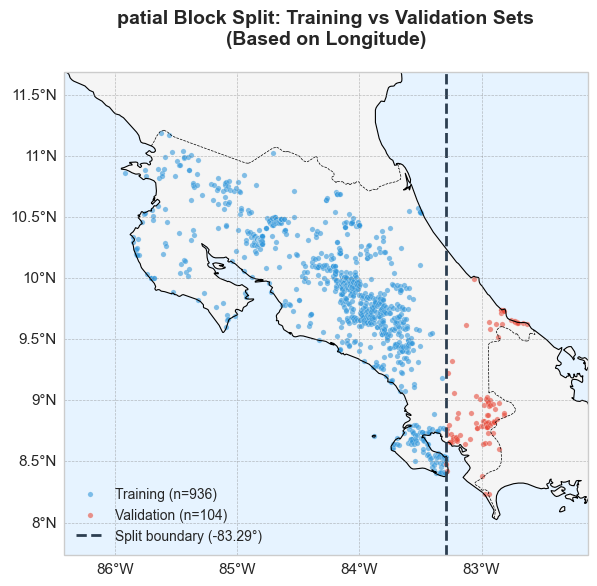

In [22]:
# Visualize the spatial split on a map
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Map extent
padding = 0.5
extent = [
    df_unique['decimalLongitude'].min() - padding,
    df_unique['decimalLongitude'].max() + padding,
    df_unique['decimalLatitude'].min() - padding,
    df_unique['decimalLatitude'].max() + padding
]
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND, facecolor='#f5f5f5')
ax.add_feature(cfeature.OCEAN, facecolor='#e6f3ff')
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle='--', linewidth=0.5)

# Plot training points (blue)
ax.scatter(train_coords[:, 0], train_coords[:, 1],
           c='#3498db', s=15, alpha=0.6, label=f'Training (n={len(train_coords):,})',
           transform=ccrs.PlateCarree(), edgecolor='white', linewidth=0.2)

# Plot validation points (red)
ax.scatter(val_coords[:, 0], val_coords[:, 1],
           c='#e74c3c', s=15, alpha=0.6, label=f'Validation (n={len(val_coords):,})',
           transform=ccrs.PlateCarree(), edgecolor='white', linewidth=0.2)

# Draw the split line using plot instead of axvline (works with cartopy projections)
lat_min, lat_max = df_unique['decimalLatitude'].min() - padding, df_unique['decimalLatitude'].max() + padding
ax.plot([lon_threshold, lon_threshold], [lat_min, lat_max], 
        color='#2c3e50', linestyle='--', linewidth=2, 
        transform=ccrs.PlateCarree(), label=f'Split boundary ({lon_threshold:.2f}°)')

# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

ax.set_title('patial Block Split: Training vs Validation Sets\n(Based on Longitude)', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='lower left', fontsize=10)

plt.tight_layout()
plt.show()

## 9. 🧠 DeepMaxent Model Training

Now we'll train the DeepMaxent model using the prepared training data. The DeepMaxent loss function implements the maximum entropy principle for species distribution modeling.

### 9.1 Data Preprocessing

Before training, we need to:
1. Handle missing values (NaN) in the environmental features
2. Normalize the features using StandardScaler

In [23]:
# Handle NaN values - remove locations with missing environmental data
train_nan_mask = torch.isnan(X_train).any(dim=1)
val_nan_mask = torch.isnan(X_val).any(dim=1)

X_train_clean = X_train[~train_nan_mask]
y_train_clean = y_train[~train_nan_mask]
X_val_clean = X_val[~val_nan_mask]
y_val_clean = y_val[~val_nan_mask]

print("🧹 Removing locations with NaN values...")
print(f"   Training: {train_nan_mask.sum().item()} locations removed → {X_train_clean.shape[0]:,} remaining")
print(f"   Validation: {val_nan_mask.sum().item()} locations removed → {X_val_clean.shape[0]:,} remaining")

# Normalize features using StandardScaler
scaler = StandardScaler()

# Fit on training data only
X_train_np = X_train_clean.numpy()
X_val_np = X_val_clean.numpy()

X_train_scaled = scaler.fit_transform(X_train_np)
X_val_scaled = scaler.transform(X_val_np)

# Convert back to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = y_train_clean
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = y_val_clean

print(f"\n✅ Data preprocessing complete!")
print(f"   X_train_tensor: {X_train_tensor.shape}")
print(f"   y_train_tensor: {y_train_tensor.shape}")
print(f"   X_val_tensor:   {X_val_tensor.shape}")
print(f"   y_val_tensor:   {y_val_tensor.shape}")

🧹 Removing locations with NaN values...
   Training: 0 locations removed → 936 remaining
   Validation: 0 locations removed → 104 remaining

✅ Data preprocessing complete!
   X_train_tensor: torch.Size([936, 19])
   y_train_tensor: torch.Size([936, 102])
   X_val_tensor:   torch.Size([104, 19])
   y_val_tensor:   torch.Size([104, 102])


### 9.2 Define Training Configuration and Model

In [24]:
# Additional imports for training
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_auc_score
import copy

# Training configuration using a simple namespace
class Args:
    def __init__(self):
        self.learning_rate = 0.0001
        self.epoch = 100
        self.hidden_nbr = 3  # Number of hidden layers
        self.weight_decay = 3e-4  # L2 regularization

args = Args()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Using device: {device}")

# Model parameters
input_size = X_train_tensor.shape[1]
output_size = y_train_tensor.shape[1]
hidden_size = 250

print(f"\n🧠 Model Architecture:")
print(f"   Input size:  {input_size} (environmental variables)")
print(f"   Hidden size: {hidden_size}")
print(f"   Output size: {output_size} (species)")
print(f"   Hidden layers: {args.hidden_nbr}")

print(f"\n⚙️ Training Configuration:")
print(f"   Learning rate: {args.learning_rate}")
print(f"   Epochs: {args.epoch}")
print(f"   Weight decay: {args.weight_decay}")
print(f"   Batch size: 250")

🖥️ Using device: cuda

🧠 Model Architecture:
   Input size:  19 (environmental variables)
   Hidden size: 250
   Output size: 102 (species)
   Hidden layers: 3

⚙️ Training Configuration:
   Learning rate: 0.0001
   Epochs: 100
   Weight decay: 0.0003
   Batch size: 250


### 9.3 Training Loop with Validation AUC

We'll implement the training loop with:
- DeepMaxent loss for optimization
- Validation AUC computed at each epoch to monitor performance
- Best model selection based on validation loss

In [25]:
def compute_auc(model, X, y, device):
    """
    Compute mean AUC across all species with sufficient data.
    
    Args:
        model: trained DeepMaxent model
        X: input features tensor
        y: target occurrence tensor
        device: computation device
    
    Returns:
        mean_auc: average AUC across species
        valid_aucs: list of AUC values for each valid species
    """
    model.eval()
    with torch.no_grad():
        X_dev = X.to(device)
        predictions = model(X_dev).cpu()
        # Apply softmax to get probabilities
        probs = torch.softmax(predictions, dim=0).numpy()
    
    y_np = y.numpy()
    
    # Convert to binary (presence/absence)
    y_binary = (y_np > 0).astype(int)
    
    valid_aucs = []
    for sp_idx in range(y_binary.shape[1]):
        # Only compute AUC if species has both presences and absences
        if y_binary[:, sp_idx].sum() > 0 and y_binary[:, sp_idx].sum() < len(y_binary):
            try:
                auc = roc_auc_score(y_binary[:, sp_idx], probs[:, sp_idx])
                valid_aucs.append(auc)
            except:
                pass
    
    mean_auc = np.mean(valid_aucs) if valid_aucs else 0.0
    return mean_auc, valid_aucs


def train_deepmodel(X_train, y_train, X_val, y_val, args, hidden_size=250, device="cuda"):
    """
    Train DeepMaxent model with validation monitoring.
    
    Returns:
        dict with model, predictions, loss history, and AUC history
    """
    # Create data loaders
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=250, shuffle=True)
    
    # Initialize model and loss
    input_size = X_train.shape[1]
    output_size = y_train.shape[1]
    
    model = deepmaxent_model(input_size, hidden_size, output_size, args.hidden_nbr)
    model = model.to(device)
    
    criterion = deepmaxent_loss().to(device)
    
    optimizer = optim.Adam(
        model.parameters(),
        lr=args.learning_rate,
        weight_decay=args.weight_decay
    )
    
    # Training history
    train_losses = []
    val_losses = []
    train_aucs = []
    val_aucs = []
    
    best_val_loss = float('inf')
    best_model_state = None
    
    print("🚀 Starting training...")
    print("=" * 60)
    
    for epoch in tqdm(range(args.epoch), desc="Training"):
        # Training phase
        model.train()
        total_train_loss = 0.0
        
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            X_val_dev = X_val.to(device)
            y_val_dev = y_val.to(device)
            val_outputs = model(X_val_dev)
            val_loss = criterion(val_outputs, y_val_dev).item()
        val_losses.append(val_loss)
        
        # Compute AUC every 10 epochs (to save time)
        if (epoch + 1) % 10 == 0 or epoch == 0:
            train_auc, _ = compute_auc(model, X_train, y_train, device)
            val_auc, _ = compute_auc(model, X_val, y_val, device)
            train_aucs.append((epoch, train_auc))
            val_aucs.append((epoch, val_auc))
            
            print(f"   Epoch {epoch+1:3d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | "
                  f"Train AUC: {train_auc:.4f} | Val AUC: {val_auc:.4f}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    # Final predictions
    model.eval()
    with torch.no_grad():
        final_predictions = model(X_train.to(device)).cpu()
    
    print("=" * 60)
    print(f" Training complete! Best validation loss: {best_val_loss:.4f}")
    
    return {
        "model": model,
        "predictions": final_predictions,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_aucs": train_aucs,
        "val_aucs": val_aucs,
        "best_val_loss": best_val_loss
    }

In [26]:
# Train the model!
results = train_deepmodel(
    X_train_tensor, 
    y_train_tensor, 
    X_val_tensor, 
    y_val_tensor, 
    args, 
    hidden_size=hidden_size, 
    device=device
)

🚀 Starting training...


Training:   5%|▌         | 5/100 [00:00<00:13,  6.97it/s]

   Epoch   1 | Train Loss: 0.0590 | Val Loss: 0.0469 | Train AUC: 0.5143 | Val AUC: 0.5141


Training:  17%|█▋        | 17/100 [00:01<00:04, 19.31it/s]

   Epoch  10 | Train Loss: 0.0556 | Val Loss: 0.0462 | Train AUC: 0.6787 | Val AUC: 0.5734


Training:  25%|██▌       | 25/100 [00:01<00:03, 19.83it/s]

   Epoch  20 | Train Loss: 0.0542 | Val Loss: 0.0455 | Train AUC: 0.7979 | Val AUC: 0.6052


Training:  35%|███▌      | 35/100 [00:02<00:03, 19.75it/s]

   Epoch  30 | Train Loss: 0.0534 | Val Loss: 0.0450 | Train AUC: 0.8695 | Val AUC: 0.6386


Training:  46%|████▌     | 46/100 [00:02<00:02, 20.64it/s]

   Epoch  40 | Train Loss: 0.0522 | Val Loss: 0.0446 | Train AUC: 0.8998 | Val AUC: 0.6507


Training:  53%|█████▎    | 53/100 [00:03<00:02, 18.09it/s]

   Epoch  50 | Train Loss: 0.0518 | Val Loss: 0.0444 | Train AUC: 0.9122 | Val AUC: 0.6665


Training:  65%|██████▌   | 65/100 [00:03<00:01, 21.85it/s]

   Epoch  60 | Train Loss: 0.0511 | Val Loss: 0.0442 | Train AUC: 0.9170 | Val AUC: 0.6782


Training:  76%|███████▌  | 76/100 [00:04<00:01, 21.73it/s]

   Epoch  70 | Train Loss: 0.0508 | Val Loss: 0.0441 | Train AUC: 0.9198 | Val AUC: 0.6746


Training:  84%|████████▍ | 84/100 [00:04<00:00, 22.10it/s]

   Epoch  80 | Train Loss: 0.0508 | Val Loss: 0.0441 | Train AUC: 0.9226 | Val AUC: 0.6751


Training:  97%|█████████▋| 97/100 [00:05<00:00, 24.29it/s]

   Epoch  90 | Train Loss: 0.0503 | Val Loss: 0.0441 | Train AUC: 0.9254 | Val AUC: 0.6717


Training: 100%|██████████| 100/100 [00:05<00:00, 17.97it/s]

   Epoch 100 | Train Loss: 0.0499 | Val Loss: 0.0441 | Train AUC: 0.9278 | Val AUC: 0.6617
 Training complete! Best validation loss: 0.0441


### 9.4 Visualize Training Progress

Let's visualize the training and validation loss curves, as well as the AUC evolution:

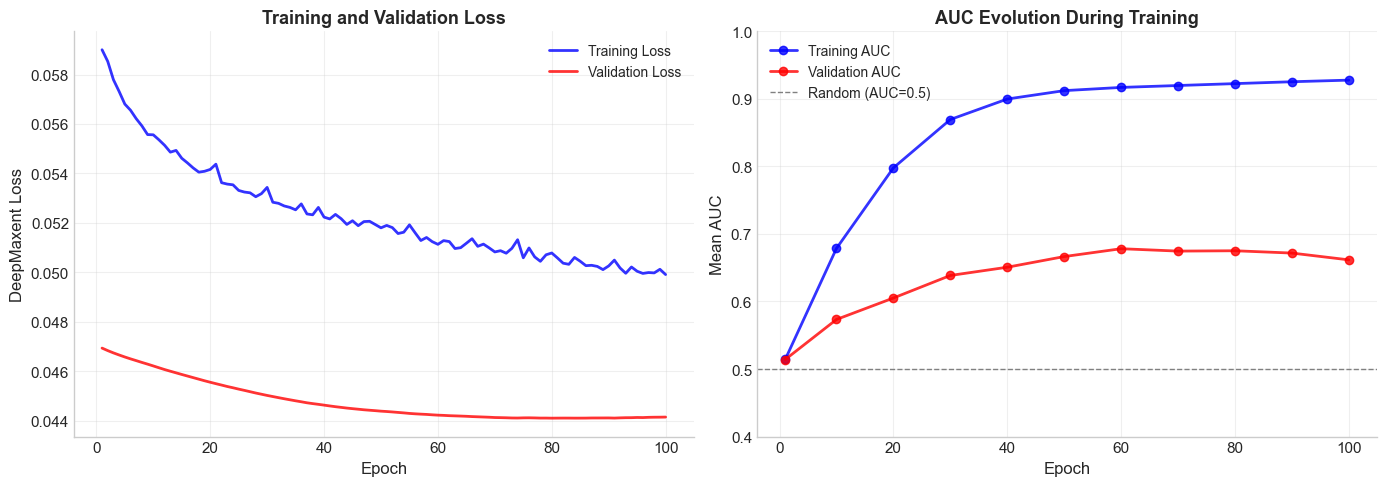


📊 FINAL METRICS
   Final Training Loss:   0.0499
   Final Validation Loss: 0.0441
   Best Validation Loss:  0.0441

   Final Training AUC:    0.9278
   Final Validation AUC:  0.6617


In [27]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
ax1 = axes[0]
epochs = range(1, len(results['train_losses']) + 1)
ax1.plot(epochs, results['train_losses'], 'b-', linewidth=2, label='Training Loss', alpha=0.8)
ax1.plot(epochs, results['val_losses'], 'r-', linewidth=2, label='Validation Loss', alpha=0.8)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('DeepMaxent Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# AUC curves
ax2 = axes[1]
train_auc_epochs = [x[0] + 1 for x in results['train_aucs']]
train_auc_values = [x[1] for x in results['train_aucs']]
val_auc_epochs = [x[0] + 1 for x in results['val_aucs']]
val_auc_values = [x[1] for x in results['val_aucs']]

ax2.plot(train_auc_epochs, train_auc_values, 'b-o', linewidth=2, markersize=6, 
         label='Training AUC', alpha=0.8)
ax2.plot(val_auc_epochs, val_auc_values, 'r-o', linewidth=2, markersize=6, 
         label='Validation AUC', alpha=0.8)
ax2.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, label='Random (AUC=0.5)')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Mean AUC', fontsize=12)
ax2.set_title('AUC Evolution During Training', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0.4, 1.0])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Print final metrics
print("\n📊 FINAL METRICS")
print("=" * 50)
print(f"   Final Training Loss:   {results['train_losses'][-1]:.4f}")
print(f"   Final Validation Loss: {results['val_losses'][-1]:.4f}")
print(f"   Best Validation Loss:  {results['best_val_loss']:.4f}")
print(f"\n   Final Training AUC:    {train_auc_values[-1]:.4f}")
print(f"   Final Validation AUC:  {val_auc_values[-1]:.4f}")

### 9.5 Detailed AUC Analysis per Species

Let's analyze the AUC distribution across species to understand model performance:

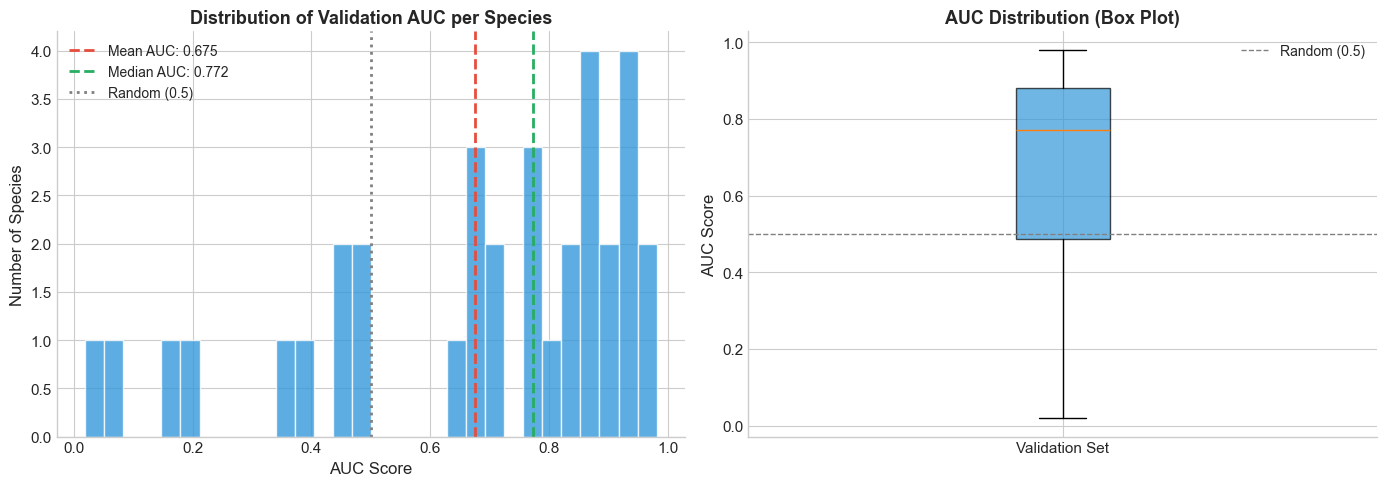


📊 VALIDATION AUC SUMMARY
   Number of species evaluated: 34
   Mean AUC:   0.6751
   Median AUC: 0.7720
   Std AUC:    0.2692
   Min AUC:    0.0194
   Max AUC:    0.9806

   Species with AUC > 0.7: 20 (58.8%)
   Species with AUC > 0.5: 24 (70.6%)


In [28]:
# Compute detailed AUC for validation set
val_mean_auc, val_species_aucs = compute_auc(results['model'], X_val_tensor, y_val_tensor, device)

# Distribution of AUC values
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of AUC values
ax1 = axes[0]
ax1.hist(val_species_aucs, bins=30, color='#3498db', edgecolor='white', alpha=0.8)
ax1.axvline(x=np.mean(val_species_aucs), color='#e74c3c', linestyle='--', linewidth=2,
            label=f'Mean AUC: {np.mean(val_species_aucs):.3f}')
ax1.axvline(x=np.median(val_species_aucs), color='#27ae60', linestyle='--', linewidth=2,
            label=f'Median AUC: {np.median(val_species_aucs):.3f}')
ax1.axvline(x=0.5, color='gray', linestyle=':', linewidth=2, label='Random (0.5)')
ax1.set_xlabel('AUC Score', fontsize=12)
ax1.set_ylabel('Number of Species', fontsize=12)
ax1.set_title('Distribution of Validation AUC per Species', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Box plot
ax2 = axes[1]
box = ax2.boxplot(val_species_aucs, vert=True, patch_artist=True)
box['boxes'][0].set_facecolor('#3498db')
box['boxes'][0].set_alpha(0.7)
ax2.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, label='Random (0.5)')
ax2.set_ylabel('AUC Score', fontsize=12)
ax2.set_title('AUC Distribution (Box Plot)', fontsize=13, fontweight='bold')
ax2.set_xticklabels(['Validation Set'])
ax2.legend(fontsize=10)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n📊 VALIDATION AUC SUMMARY")
print("=" * 50)
print(f"   Number of species evaluated: {len(val_species_aucs)}")
print(f"   Mean AUC:   {np.mean(val_species_aucs):.4f}")
print(f"   Median AUC: {np.median(val_species_aucs):.4f}")
print(f"   Std AUC:    {np.std(val_species_aucs):.4f}")
print(f"   Min AUC:    {np.min(val_species_aucs):.4f}")
print(f"   Max AUC:    {np.max(val_species_aucs):.4f}")
print(f"\n   Species with AUC > 0.7: {sum(np.array(val_species_aucs) > 0.7)} ({100*sum(np.array(val_species_aucs) > 0.7)/len(val_species_aucs):.1f}%)")
print(f"   Species with AUC > 0.5: {sum(np.array(val_species_aucs) > 0.5)} ({100*sum(np.array(val_species_aucs) > 0.5)/len(val_species_aucs):.1f}%)")

## 10. 🗺️ Generate Species Suitability Maps

Now that we have a trained model, we'll apply it to the entire study area to generate **suitability maps** for each species. This involves:

1. Loading all bioclimatic rasters as a stack
2. Applying the same preprocessing (StandardScaler) used during training
3. Running the model on each pixel
4. Converting outputs to suitability probabilities

In [29]:
# Load all rasters and stack them in the correct order
print("📂 Loading rasters in training order...")
print(f"   Raster directory: {rasters_dir}")
print(f"   Number of variables: {len(raster_files)}")

# Load the first raster to get metadata
with rasterio.open(os.path.join(rasters_dir, raster_files[0])) as src:
    raster_height = src.height
    raster_width = src.width
    raster_transform_map = src.transform
    raster_crs_map = src.crs
    raster_bounds = src.bounds

print(f"\n📐 Raster dimensions: {raster_width} × {raster_height} pixels")
print(f"   Total pixels: {raster_width * raster_height:,}")

# Stack all rasters in the same order as training
raster_stack = np.zeros((len(raster_files), raster_height, raster_width), dtype=np.float32)

for i, filename in enumerate(tqdm(raster_files, desc="Loading rasters")):
    filepath = os.path.join(rasters_dir, filename)
    with rasterio.open(filepath) as src:
        data = src.read(1).astype(np.float32)
        nodata_val = src.nodata
        
        # Replace nodata with NaN
        if nodata_val is not None:
            data[data == nodata_val] = np.nan
        # Also mask extreme values
        data[np.abs(data) > 1e10] = np.nan
        
        raster_stack[i] = data

print(f"\n✅ Raster stack shape: {raster_stack.shape}")
print(f"   Order of variables:")
for i, f in enumerate(raster_files):
    print(f"   {i}: {f}")

📂 Loading rasters in training order...
   Raster directory: data/tutorial/cropped_rasters/
   Number of variables: 19

📐 Raster dimensions: 418 × 378 pixels
   Total pixels: 158,004


Loading rasters: 100%|██████████| 19/19 [00:00<00:00, 247.46it/s]


✅ Raster stack shape: (19, 378, 418)
   Order of variables:
   0: CHELSA_bio10_1981-2010_V.2.1.tif
   1: CHELSA_bio11_1981-2010_V.2.1.tif
   2: CHELSA_bio12_1981-2010_V.2.1.tif
   3: CHELSA_bio13_1981-2010_V.2.1.tif
   4: CHELSA_bio14_1981-2010_V.2.1.tif
   5: CHELSA_bio15_1981-2010_V.2.1.tif
   6: CHELSA_bio16_1981-2010_V.2.1.tif
   7: CHELSA_bio17_1981-2010_V.2.1.tif
   8: CHELSA_bio18_1981-2010_V.2.1.tif
   9: CHELSA_bio19_1981-2010_V.2.1.tif
   10: CHELSA_bio1_1981-2010_V.2.1.tif
   11: CHELSA_bio2_1981-2010_V.2.1.tif
   12: CHELSA_bio3_1981-2010_V.2.1.tif
   13: CHELSA_bio4_1981-2010_V.2.1.tif
   14: CHELSA_bio5_1981-2010_V.2.1.tif
   15: CHELSA_bio6_1981-2010_V.2.1.tif
   16: CHELSA_bio7_1981-2010_V.2.1.tif
   17: CHELSA_bio8_1981-2010_V.2.1.tif
   18: CHELSA_bio9_1981-2010_V.2.1.tif


In [30]:
# Reshape raster stack for model prediction
# From (n_variables, height, width) to (n_pixels, n_variables)
n_pixels = raster_height * raster_width

# Reshape: (variables, height, width) -> (height*width, variables)
X_raster = raster_stack.reshape(len(raster_files), -1).T  # Shape: (n_pixels, n_variables)

print(f"📐 Reshaped for prediction: {X_raster.shape}")

# Create mask for valid pixels (no NaN in any variable)
valid_pixel_mask = ~np.isnan(X_raster).any(axis=1)
n_valid_pixels = valid_pixel_mask.sum()

print(f"   Valid pixels: {n_valid_pixels:,} / {n_pixels:,} ({100*n_valid_pixels/n_pixels:.1f}%)")

# Extract only valid pixels for prediction
X_valid = X_raster[valid_pixel_mask]

# Apply the same scaler used during training
print("\n🔄 Applying StandardScaler (same as training)...")
X_valid_scaled = scaler.transform(X_valid)

# Convert to tensor
X_valid_tensor = torch.tensor(X_valid_scaled, dtype=torch.float32)
print(f"   Tensor shape for prediction: {X_valid_tensor.shape}")

📐 Reshaped for prediction: (158004, 19)
   Valid pixels: 158,004 / 158,004 (100.0%)

🔄 Applying StandardScaler (same as training)...
   Tensor shape for prediction: torch.Size([158004, 19])


In [31]:
# Run model prediction on the raster data
print("🧠 Running model prediction on raster pixels...")

model = results['model']
model.eval()
model = model.to(device)

# Predict in batches to avoid memory issues
batch_size = 10000
n_batches = (len(X_valid_tensor) + batch_size - 1) // batch_size

predictions_list = []

with torch.no_grad():
    for i in tqdm(range(n_batches), desc="Predicting"):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(X_valid_tensor))
        
        batch = X_valid_tensor[start_idx:end_idx].to(device)
        batch_pred = model(batch).cpu()
        predictions_list.append(batch_pred)

# Concatenate all predictions
predictions_valid = torch.cat(predictions_list, dim=0)

# Apply softmax to get suitability probabilities (along spatial dimension)
# This gives relative suitability across space for each species
suitability_valid = torch.softmax(predictions_valid, dim=0).numpy()

print(f"\n✅ Predictions complete!")
print(f"   Suitability shape: {suitability_valid.shape}")
print(f"   (n_valid_pixels, n_species) = ({n_valid_pixels:,}, {num_species:,})")

🧠 Running model prediction on raster pixels...


Predicting: 100%|██████████| 16/16 [00:00<00:00, 176.81it/s]



✅ Predictions complete!
   Suitability shape: (158004, 102)
   (n_valid_pixels, n_species) = (158,004, 102)


In [32]:
# Reconstruct full suitability maps (including NaN pixels)
print("🗺️ Reconstructing suitability maps...")

# Initialize full suitability array with NaN
suitability_maps = np.full((num_species, n_pixels), np.nan, dtype=np.float32)

# Fill in valid pixels
suitability_maps[:, valid_pixel_mask] = suitability_valid.T  # Transpose to (species, pixels)

# Reshape to (n_species, height, width)
suitability_maps = suitability_maps.reshape(num_species, raster_height, raster_width)

print(f"✅ Suitability maps shape: {suitability_maps.shape}")
print(f"   (n_species, height, width) = ({num_species:,}, {raster_height}, {raster_width})")

# Create species index to name mapping
idx_to_species = {idx: species for species, idx in species_to_idx.items()}

# Find top species by number of occurrences for visualization
species_occurrence_counts = y_tensor.sum(dim=0).numpy()
top_species_indices = np.argsort(species_occurrence_counts)[::-1][:10]

print(f"\n📊 Top 10 species by occurrence count:")
for rank, sp_idx in enumerate(top_species_indices, 1):
    sp_name = idx_to_species[sp_idx]
    count = int(species_occurrence_counts[sp_idx])
    print(f"   {rank:2d}. {sp_name}: {count} occurrences")

🗺️ Reconstructing suitability maps...
✅ Suitability maps shape: (102, 378, 418)
   (n_species, height, width) = (102, 378, 418)

📊 Top 10 species by occurrence count:
    1. Coffea arabica: 344 occurrences
    2. Puya dasylirioides: 106 occurrences
    3. Hibiscus rosa-sinensis: 72 occurrences
    4. Tectona grandis: 71 occurrences
    5. Musa coccinea: 65 occurrences
    6. Quercus insignis: 42 occurrences
    7. Peperomia rotundifolia: 39 occurrences
    8. Gunnera talamancana: 27 occurrences
    9. Oxalis corniculata: 22 occurrences
   10. Cedrela odorata: 21 occurrences


### 10.1 Visualize Suitability Maps for Top Species

Let's visualize the predicted suitability maps for the most observed species:

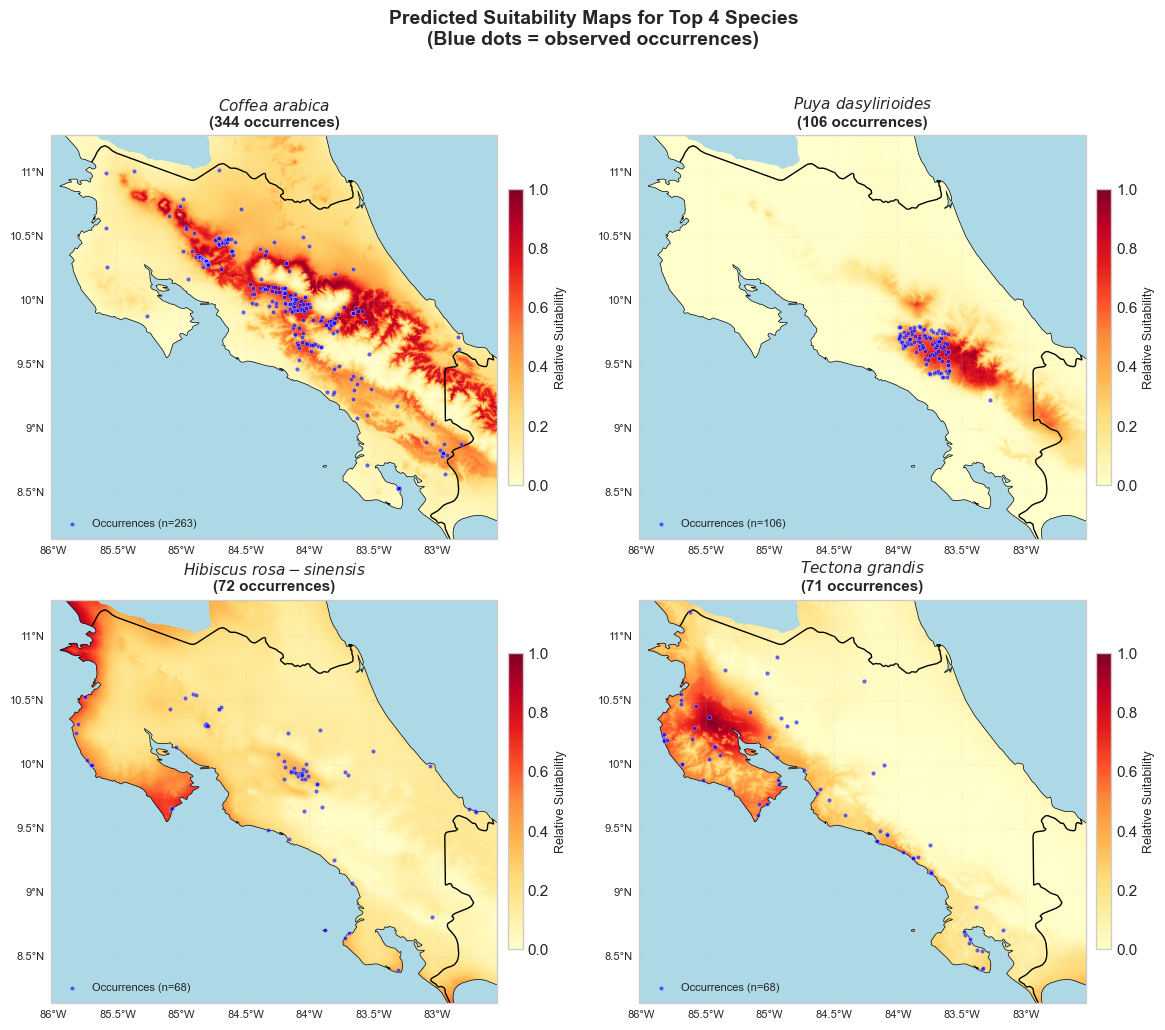

In [33]:
# Plot suitability maps for top 4 species
fig, axes = plt.subplots(2, 2, figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

# Raster extent for plotting
extent_map = [raster_bounds.left, raster_bounds.right, raster_bounds.bottom, raster_bounds.top]

for ax, sp_idx in zip(axes, top_species_indices[:4]):
    sp_name = idx_to_species[sp_idx]
    suitability = suitability_maps[sp_idx]
    
    # Mask NaN values
    suitability_masked = np.ma.masked_invalid(suitability)
    
    # Normalize for better visualization (0-1 range based on this species)
    suit_min = np.nanmin(suitability)
    suit_max = np.nanmax(suitability)
    if suit_max > suit_min:
        suitability_norm = (suitability_masked - suit_min) / (suit_max - suit_min)
    else:
        suitability_norm = suitability_masked
    
    # Set map style (no ocean/lakes)
    ax.set_facecolor('honeydew')
    oceans = cfeature.NaturalEarthFeature('physical', 'ocean', '10m', edgecolor='none', facecolor='lightblue')
    ax.add_feature(oceans, zorder=2)
    lakes = cfeature.NaturalEarthFeature('physical', 'lakes', '10m', edgecolor='none', facecolor='lightblue')
    ax.add_feature(lakes, zorder=2)
    ax.add_feature(cfeature.BORDERS, zorder=2)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=2)
    
    # Plot suitability map
    im = ax.imshow(suitability_norm, extent=extent_map, origin='upper', 
                   cmap='YlOrRd', transform=ccrs.PlateCarree(), vmin=0, vmax=1, zorder=1)
    
    # Get occurrence points for this species
    sp_occurrences = y_tensor[:, sp_idx].numpy()
    has_occurrence = sp_occurrences > 0
    if has_occurrence.any():
        occ_lons = df_unique['decimalLongitude'].values[has_occurrence]
        occ_lats = df_unique['decimalLatitude'].values[has_occurrence]
        ax.scatter(occ_lons, occ_lats, c='blue', s=10, alpha=0.6, 
                   transform=ccrs.PlateCarree(), edgecolor='white', linewidth=0.3,
                   label=f'Occurrences (n={has_occurrence.sum()})', zorder=3)
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.7, pad=0.02)
    cbar.set_label('Relative Suitability', fontsize=9)
    
    # Gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.3, alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'fontsize': 8}
    gl.ylabel_style = {'fontsize': 8}
    
    # Title with species name in italic
    ax.set_title(f'$\it{{{sp_name.replace(" ", "\ ")}}}$\n({int(species_occurrence_counts[sp_idx])} occurrences)', 
                 fontsize=11, fontweight='bold')
    ax.legend(loc='lower left', fontsize=8)

plt.suptitle('Predicted Suitability Maps for Top 4 Species\n(Blue dots = observed occurrences)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 10.2 Species Suitability Richness Prediction Map

We can also create a predicted species common suitability map by summing suitabilities across all species:

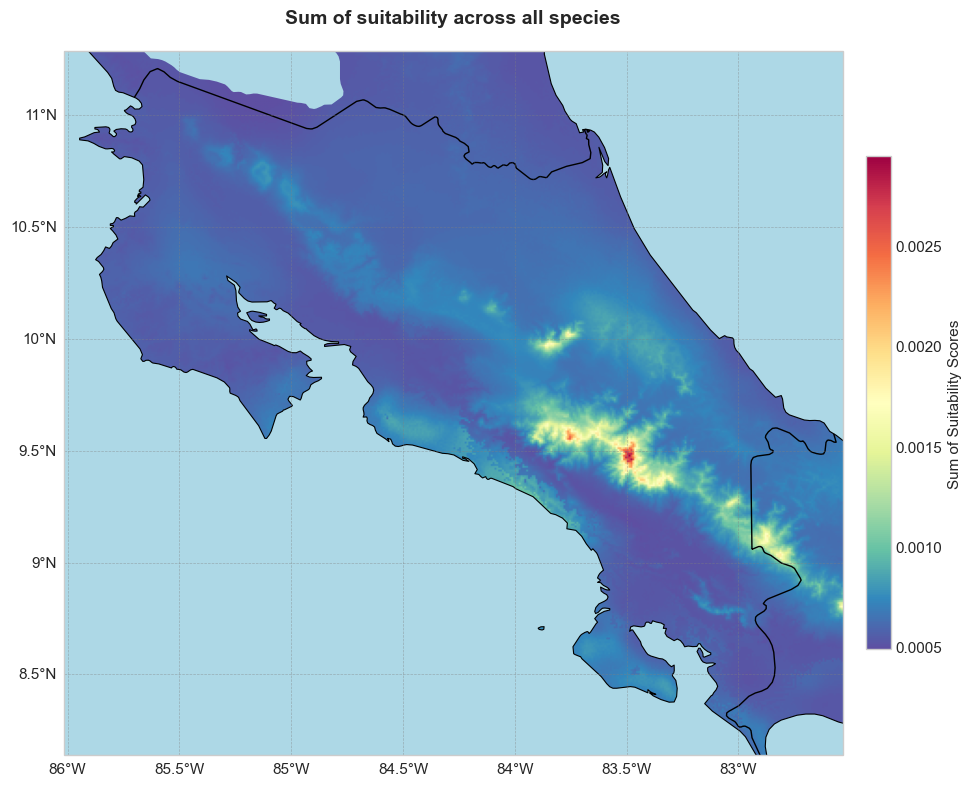

Predicted Richness Statistics:
   Min: 0.0005
   Max: 0.0029
   Mean: 0.0006


In [34]:
# Compute predicted a sum of suitability across species(sum of suitabilities)
# This gives an indication of how many species are predicted to be suitable at each location

# Sum suitabilities across all species
predicted_richness = np.nansum(suitability_maps, axis=0)
predicted_richness_masked = np.ma.masked_invalid(predicted_richness)

# Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Set map style (no ocean/lakes visible over land)
ax.set_facecolor('honeydew')
oceans = cfeature.NaturalEarthFeature('physical', 'ocean', '10m', edgecolor='none', facecolor='lightblue')
ax.add_feature(oceans, zorder=2)
lakes = cfeature.NaturalEarthFeature('physical', 'lakes', '10m', edgecolor='none', facecolor='lightblue')
ax.add_feature(lakes, zorder=2)
ax.add_feature(cfeature.BORDERS, zorder=2)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, zorder=2)

# Plot predicted richness
im = ax.imshow(predicted_richness_masked, extent=extent_map, origin='upper', 
               cmap='Spectral_r', transform=ccrs.PlateCarree(), zorder=1)

# Colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.7, pad=0.02)
cbar.set_label('Sum of Suitability Scores', fontsize=11)

# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

ax.set_title('Sum of suitability across all species', 
             fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print(f"Predicted Richness Statistics:")
print(f"   Min: {np.nanmin(predicted_richness):.4f}")
print(f"   Max: {np.nanmax(predicted_richness):.4f}")
print(f"   Mean: {np.nanmean(predicted_richness):.4f}")

### 10.3 Save Suitability Maps as GeoTIFF (Optional)

We can export the suitability maps as GeoTIFF files for use in GIS software:

In [35]:
# Create output directory for suitability maps
output_suitability_dir = 'data/tutorial/suitability_maps'
os.makedirs(output_suitability_dir, exist_ok=True)

# Save suitability maps for top 10 species
print("💾 Saving suitability maps as GeoTIFF...")

for sp_idx in tqdm(top_species_indices[:10], desc="Saving"):
    sp_name = idx_to_species[sp_idx]
    # Clean species name for filename
    sp_name_clean = sp_name.replace(' ', '_').replace('.', '')
    
    suitability = suitability_maps[sp_idx]
    
    # Define output path
    output_path = os.path.join(output_suitability_dir, f'suitability_{sp_name_clean}.tif')
    
    # Write GeoTIFF
    with rasterio.open(
        output_path, 'w',
        driver='GTiff',
        height=raster_height,
        width=raster_width,
        count=1,
        dtype=np.float32,
        crs=raster_crs_map,
        transform=raster_transform_map,
        nodata=np.nan
    ) as dst:
        dst.write(suitability, 1)

# Also save the species richness map
richness_path = os.path.join(output_suitability_dir, 'predicted_species_richness.tif')
with rasterio.open(
    richness_path, 'w',
    driver='GTiff',
    height=raster_height,
    width=raster_width,
    count=1,
    dtype=np.float32,
    crs=raster_crs_map,
    transform=raster_transform_map,
    nodata=np.nan
) as dst:
    dst.write(predicted_richness.astype(np.float32), 1)

print(f"\n✅ Saved {len(top_species_indices[:10]) + 1} GeoTIFF files to: {output_suitability_dir}")
print(f"   - 10 species suitability maps")
print(f"   - 1 predicted species richness map")

💾 Saving suitability maps as GeoTIFF...


Saving:   0%|          | 0/10 [00:00<?, ?it/s]

Saving: 100%|██████████| 10/10 [00:00<00:00, 36.44it/s]


✅ Saved 11 GeoTIFF files to: data/tutorial/suitability_maps
   - 10 species suitability maps
   - 1 predicted species richness map


## 🎯 Final Summary

In this tutorial, we have successfully:

1. ✅ **Loaded and explored** GBIF biodiversity data from Costa Rica
2. ✅ **Visualized** species occurrences on interactive maps
3. ✅ **Cropped environmental rasters** (WorldClim bioclimatic variables)
4. ✅ **Built training tensors** (X and y)
5. ✅ **Implemented spatial block split** for train/validation
6. ✅ **Trained a DeepMaxent model** with the custom loss function
7. ✅ **Evaluated model performance** using AUC metrics
8. ✅ **Generated suitability maps** by applying the model to rasters
9. ✅ **Exported results** as GeoTIFF files

### 📊 Key Results

| Metric | Value |
|--------|-------|
| Number of species | See training output |
| Training samples | See training output |
| Validation AUC | See training output |
| Suitability maps generated | 10 species + richness map |

### 🚀 Next Steps

- Compare suitability predictions with independent validation data
- Generate future climate projections using climate scenarios
- Apply ensemble methods for uncertainty quantification
- Compare with MaxEnt or other SDM approaches

---
*Tutorial created for the DeepMaxent project - Species Distribution Modeling with Deep Learning*